# IMPORTS

In [ ]:
import numpy as np
import sklearn
import scipy as sci
import scipy.stats as ss
import scipy.optimize as opt
import matplotlib.pyplot as plt
import graphviz
import sys, math, os, copy
import networkx as nx
import graphviz
import covar
import networkx as nx
from sklearn.metrics import roc_curve, auc, confusion_matrix
from scipy.stats import norm, beta
from scipy.special import gamma
from itertools import combinations, permutations
from math import log, exp, log2
from operator import itemgetter, attrgetter
from inverse_covariance import ModelAverage, QuicGraphLassoEBIC, QuicGraphLasso, QuicGraphLassoCV,AdaptiveGraphLasso

os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'

## UTILS

In [ ]:
def cov2cor( A ):
    """
    covariance matrix to correlation matrix.
    """
    d = np.sqrt(A.diagonal())
    A = ((A.T/d).T)/d
    return A

def cov2pcor(cov):
#    cov = np.cov(X, rowvar=False)
    D, _ = cov.shape
    sigma = -np.linalg.pinv(cov)
    for i in range(D):
        sigma[i,i] = -1*sigma[i,i]
    pi_obs = cov2cor(sigma)
    return pi_obs

def pcor2cov(pi):
    pi = -pi
    for i in range(D):
        pi[i,i] = -1*pi[i,i]
    
    return np.linalg.inv(pi)

def pcor2prec(pi):
    pi = -pi
    for i in range(D):
        pi[i,i] = -1*pi[i,i]
    return pi

def prec2pcor(pi):
    pi = cov2cor(pi)
    return pi

def generate_graph(pi):
    D, _ = pi.shape
    G = nx.Graph()
    G.add_nodes_from(range(D))   
    
    for i in range(D):
        for j in range(i):
            if abs(pi[i, j]) > 1e-8:
                G.add_edge(i, j)
            else:
                pass
    return G

def generate_empty_graph(pi):
    D, _ = pi.shape
    G = nx.Graph()
    G.add_nodes_from(range(D))   
    return G

def calculate_entropy(X, steps):
    # establish ranges for X
    lo, hi, N = min(X), max(X) + 1e-8, X.shape[0]
    entropy = 0.0
    for i in range(steps):
        xl = (lo + (hi-lo)*(i*1.0/steps))
        xh = lo + (hi - lo)*( (i+1.0) / steps)
        tmp = ((xl <= X) & (X < xh)).sum()
        if tmp == 0:
            continue
        else:
            p = 1.0 * tmp / N
            entropy -= p * log2(p)
    return entropy
    
def calculate_joint_entropy(X, Y, steps):
    X_lo, X_hi, N = min(X), max(X) + 1e-8, X.shape[0]
    Y_lo, Y_hi = min(Y), max(Y) + 1e-8
    entropy = 0.0
    cnt = 0
    for i in range(steps):
        for j in range(steps):
            xl = X_lo + (X_hi - X_lo)*(i*1.0/steps)
            xh = X_lo + (X_hi - X_lo)*( (i+1.0) / steps)
            
            yl = Y_lo + (Y_hi - Y_lo)*(j*1.0/steps)
            yh = Y_lo + (Y_hi - Y_lo)*( (j+1.0) / steps)
        
            tmp = ((xl <= X) & (X < xh) & (yl <= Y) & (Y < yh)).sum()
            if tmp == 0:
                continue
            else:
                cnt += tmp
                p = 1.0 * tmp / N
                entropy -= p * log2(p)
    return entropy
    
def calculate_mutual_information(X, Y, steps=10):
    h_X = calculate_entropy(X, steps)
    h_Y = calculate_entropy(Y, steps)
    h_XY = calculate_joint_entropy(X, Y, steps)
    return h_X + h_Y - h_XY

def partial_corr(X, i, j, k):
    D = X.shape[1]
    idx = np.zeros(D, dtype=np.bool)
    for k_val in k:
        idx[k_val] = True
    
    if len(k) > 0:
        beta_i = sci.linalg.lstsq(X[:, idx], X[:, j])[0]
        beta_j = sci.linalg.lstsq(X[:, idx], X[:, i])[0]

        res_j = X[:, j] - X[:, idx].dot(beta_i)
        res_i = X[:, i] - X[:, idx].dot(beta_j)

        corr = ss.pearsonr(res_i, res_j)[0]
    else:
        corr = ss.pearsonr(X[:, i], X[:, j])[0]
    
    return corr

## GAUSSIAN DATA SIMULATOR

In [ ]:
def simulate_correlation_matrix(num_nodes, frac_edges, mean=0):
    N = num_nodes
    mu_A = frac_edges
    eps = 10**-4
    cors = np.random.uniform(low=-1.0, high=1.0, size=(N, N))
    edges = np.random.choice(2, size=(N,N), p=(1.0 - frac_edges, frac_edges))
    edges = np.tril(edges, -1)
    edges = np.multiply(edges, cors)
    edges = edges + np.transpose(edges)
    abs_edges = np.absolute(edges)
    
    col_sums = np.sum(abs_edges, axis=0) # columnwise
    col_sums = np.maximum(col_sums, np.ones(D))
    col_sums = np.add(col_sums, np.array([eps]*N))
    col_sums = np.diag(col_sums)
    
    pi = col_sums + edges
    pi = cov2cor(pi)
    return pi

# Returns samples of data multivariate Gaussian distributed

def simulate_gaussian_data(num_samples, dim, frac_edges, pcor=None):
    N = num_samples
    D = dim
    
    if pcor is None:
        pcor = simulate_correlation_matrix(D, frac_edges)
    else:
        pass
    
    P = pcor2cov(pcor)
    sample_data = np.random.multivariate_normal(mean=np.array([0.0]*D),
                                                cov=P,
                                                size=N)
    
    return sample_data, pcor

## NETWORK METRIC CALCULATOR

In [14]:
def generate_network_metrics(g_true, g_pred):
    D = len(g_true.nodes())
    actual, pred = np.zeros((D, D)), np.zeros((D, D))
    for e in g_true.edges():
        i, j = e
        actual[i,j], actual[j,i] = 1, 1
    for e in g_pred.edges():
        i, j = e
        pred[i,j], pred[j,i] = 1, 1
    il = np.tril_indices(D, k=-1)
    actual, pred = actual[il], pred[il]
    
    cf = confusion_matrix(actual, pred)
    
    ### Metrics to be returned
    tn, fp, fn, tp = cf[0][0], cf[0][1], cf[1][0], cf[1][1]
    
    sens = tp / (tp + fn)
    spec = tn / (tn + fp)
    fpr = fp / (fp + tn)
    if tp + fp < 1e-8:
        ppv = 0.0
    else:
        ppv = tp / (tp + fp)
    denominator = (tp+fp) * (tp + fn) * (tn + fp) * (tn+fn)
    if denominator < 1e-8:
        denominator = 1.0
    mcc = (tp * tn - fp * fn) / ( denominator )**0.5
    
    if sens < 1e-9 or ppv < 1e-9:
        f1_score = 0
    else:
        f1_score = 2.0 / ( (1.0/sens) + (1.0/ppv))
    
    hd = sum(abs(pred - actual))
    accuracy = (tp+tn) / (tp+tn+fp+fn)
    
    return (sens, spec, fpr, ppv, mcc, f1_score, accuracy, hd)

## RELEVANCE NETWORKS

In [ ]:
class RelevanceNetworks():
    
    def __init__(self, threshold=0.99):
        self._alpha = 0.99
        self.scores_ = None
        self.network_ = None
    
    def fit(self, sample_data):
        X = sample_data
        N, D = X.shape
        mutual_inf = np.zeros((D,D))
        
        for i in range(D):
            for j in range(i):
                mi = calculate_mutual_information(X[:, i], X[:, j], steps=int(log2(N)))
                mutual_inf[i, j], mutual_inf[j, i] = mi, mi

        # Calculate the MI threshold using permutations
        permutated_mi_vals = []
        for tt in range(1000):
            idx1 = np.random.randint(0, D)
            idx2 = np.random.randint(0, D)
            if idx1 == idx2:
                continue
            A, B = X[:, idx1], X[:, idx2]
            A = np.random.permutation(A)
            mi = calculate_mutual_information(A, B, steps=int(log2(N)))
            permutated_mi_vals.append(mi)

        permutated_mi_vals = sorted(permutated_mi_vals)
        threshold = permutated_mi_vals[int(len(permutated_mi_vals) * self._alpha)]
        
        gr_pred = nx.Graph()
        gr_pred.add_nodes_from(range(D))
        for i in range(D):
            for j in range(i):
                if mutual_inf[i, j] > threshold:
                    gr_pred.add_edge(i,j)
                else:
                    pass
        
        self.scores_ = mutual_inf
        self.network_ = gr_pred
        return

## FISHER APPROXIMATION

In [ ]:
class FisherApproximation():
    
    def __init__(self, threshold=0.95, bonf_correction=True):
        self._alpha = threshold
        self._use_bonf = bonf_correction
        self.scores_ = None
        self.network_ = None
    
    def fit(self, sample_data):
        X = sample_data
        N, D = X.shape    
        scores = np.zeros((D,D))
        cov = np.cov(X, rowvar=False)

        sigma = -np.linalg.inv(cov)
        for i in range(D):
            sigma[i,i] = -1*sigma[i,i]
        pi_obs = cov2cor(sigma)

        if self._use_bonf:
            n_tests = 0.5*D*(D-1)
            threshold = self._alpha / n_tests
        else:
            threshold = self._alpha
        
        gr_pred = nx.Graph()
        gr_pred.add_nodes_from(range(D))
        
        for i in range(D):
            for j in range(i):
                v = pi_obs[i,j]
                # Do the fisher transform
                zij = 0.5*log( (1+v) / (1-v) )
                zscore = (N - D + 2 - 3)**0.5 * abs(zij)
                scores[i,j] = 1 - 2*(1 - norm.cdf(zscore))
                scores[j,i] = scores[i,j]
                
                if norm.cdf(zscore) > 1 - 0.5*threshold:
                    gr_pred.add_edge(i,j)
                else:
                    pass
        self.scores_ = scores
        self.network_ = gr_pred
        return

## PC ALGORITHM

In [ ]:
class PCAlgorithm():
    
    def __init__(self, threshold=0.99, stable=True):
        self._alpha = 1.0 - threshold
        self._stable = stable
        self.scores_ = None
        self.network_ = None
            
    def fisher_test(self, X, i, j, k):
        pcorr = partial_corr(X, i, j, k)
        zij = 0.5*log( (1+pcorr) / (1-pcorr) )
        zscore = (N - len(k) - 3)**0.5 * abs(zij)
        pval = 2*(1-norm.cdf(zscore))
        return pval
    

    def fit(self, sample_data):
        X = sample_data
        N, D = X.shape
        node_ids = range(X.shape[1])

        g = nx.Graph()
        g.add_nodes_from(node_ids)
        for (i, j) in combinations(node_ids, 2):
            g.add_edge(i, j)

        l = 0
        max_reach = D-2
        while True:
            cont = False
            remove_edges = []
            for (i, j) in permutations(node_ids, 2):
                adj_i = list(g.neighbors(i))
                if j not in adj_i:
                    continue
                else:
                    adj_i.remove(j)
                    pass
                if len(adj_i) >= l:
                    if len(adj_i) < l:
                        continue
                    for k in combinations(adj_i, l):
                        p_val = self.fisher_test(X, i, j, set(k))
                        if p_val > self._alpha:
                            if g.has_edge(i, j):
                                if self._stable:
                                    remove_edges.append((i, j))
                                else:
                                    g.remove_edge(i, j)
                                pass
                            break
                        pass
                    cont = True
                    pass
                pass
            l += 1
            if self._stable:
                g.remove_edges_from(remove_edges)
            if cont is False:
                break
            if l > max_reach:
                break
            pass

        self.network_ = g
        return 

## Graphical Lasso

In [ ]:
class GraphicalLasso():
    def __init__(self, threshold=0.0, use_ebic=False, gamma=0.0):
        self._threshold = threshold
        self._use_ebic = use_ebic
        self._gamma = gamma
        
        self.scores_ = None
        self.network_ = None
    
    def fit(self, X):
        N, D = X.shape
        g = nx.Graph()
        g.add_nodes_from(range(D))
        scores = np.zeros((D,D))
        
        if self._use_ebic:
            model = QuicGraphLassoEBIC(gamma=self._gamma)
        else:
            model = QuicGraphLassoCV()
        model.fit(X)
        pi = prec2pcor(model.precision_)
        
        for i in range(D):
            for j in range(i):
                v = pi[i,j]
                scores[i,j], scores[j,i] = abs(v), abs(v)
                
                if abs(v) > self._threshold:
                    g.add_edge(i,j)
        
        self.scores_ = scores
        self.network_ = g
        return

## MIXTURE MODEL

In [ ]:
class MixtureModel():
    def __init__(self, fdr_rate=0.1):
        self._Q = fdr_rate
        self.scores_ = None
        self.network_ = None
        
    
    def neg_log_likelihood(self, x, *args):
        data = list(args[0])
        N = len(data)
        ll = 0.0
        eta, k = x[0], x[1]
        
        for i in range(N):
            p = data[i]
            #f0 = (1 - p*p)**(0.5*(k-3)) * gamma(k/2) / (math.pi * gamma(0.5*(k-1)))
            f0 = abs(p) * beta.pdf(p*p, 0.5, 0.5*(k-1))
            fA = 1 # Assume the alternative distribution ~ U[-1,1]        
            tmp = (1-eta) * f0 + eta * fA
            ll -= log(tmp)

        return ll

    def optimize_mixture_model(self, X):
        eta, k = 0.03, 100.0
        res = opt.minimize(self.neg_log_likelihood, 
                     x0=(eta, k), 
                     args=X,
                     bounds=((1e-6, 0.5), (10, None)),
                     options={'gtol': 1e-6, 'disp': False})
        return res.x


    def calculate_p_values(self, pi_arr, k):
        n, p_vals = len(pi_arr), []
        for i in range(n):
            r = pi_arr[i]
            t_val = r * math.sqrt((k-1) / (1 - r*r))
            p_val = 2 * (1 - ss.t.cdf(abs(t_val), k) )
            p_vals.append((r, p_val, i))
        return p_vals

    def fit(self, X):
        N, D = X.shape
        E = 0.5*D*(D-1)
        g = nx.Graph()
        g.add_nodes_from(range(D))
        scores = np.zeros((D,D))
        
        cov_shrink, _ = covar.cov_shrink_ss(X)
        pi = cov2pcor(cov_shrink)

        # Indices of the lower triangle
        il = np.tril_indices(D, k=-1)
        pi_elems = pi[il]

        # Fit the mixture model
        params = self.optimize_mixture_model(pi_elems)
        eta_est, k_est = params
        N_eff = k_est + D - 1

        # Calculate the p-values using t-test
        p_vals = self.calculate_p_values(pi_elems, k_est)
        p_vals = sorted(p_vals, key=itemgetter(1))

        # False Discovery Rate multiple testing (Benjamini and Hochberg, 1995)
        for i, v in enumerate(p_vals):
            r, p, idx = v
            
            i_idx, j_idx = il[0][idx], il[1][idx]
            scores[i_idx, j_idx], scores[j_idx, i_idx] = p, p
            
            if p <= ((i+1)/E) * self._Q :
                g.add_edge(i_idx, j_idx)
            else:
                break
        
        self.network_ = g
        self.scores_ = scores
        return

## RUN SIMULATIONS

In [ ]:
metric_names = ['sens', 'spec', 'fpr', 'ppv', 'mcc', 'f1_score', 'accuracy', 'hd']
method_names = ['RN', 'PC', 'Mixture', 'GL-CV', 'GL-BIC', 'FA', 'Empty']
num_tests, num_methods, num_metrics = 100, len(method_names), len(metric_names)

metrics = np.zeros((num_tests, num_methods, num_metrics))
params = np.zeros((num_tests, 3))
for tt in range(num_tests):
    D = np.random.randint(low=10, high=50)
    N = np.random.randint(low=500, high=1500)
    ne = 2 + 2*np.random.rand()
    print('Test #%i: D=%i, N=%i, ne=%.2f' % (tt, D, N, ne))
    eta = ne / (D-1.0)
    params[tt,:] = [N, D, eta]
    
    sample_data, pcor = simulate_gaussian_data(N, D, eta)
    actual_network = generate_graph(pcor)
    empty_network = generate_empty_graph(pcor)
    metrics[tt, 6, :] = generate_network_metrics(actual_network, empty_network)
    
    fa_model = FisherApproximation()
    fa_model.fit(sample_data)
    metrics[tt, 5, :] = generate_network_metrics(actual_network, fa_model.network_)
    
    
    rn_model = RelevanceNetworks()
    rn_model.fit(sample_data)
    metrics[tt, 0, :] = generate_network_metrics(actual_network, rn_model.network_)
    
    pc_model = PCAlgorithm()
    pc_model.fit(sample_data)
    metrics[tt, 1, :] = generate_network_metrics(actual_network, pc_model.network_)
    
    mix_model = MixtureModel()
    mix_model.fit(sample_data)
    metrics[tt, 2, :] = generate_network_metrics(actual_network, mix_model.network_)

    gl_model = GraphicalLasso()
    gl_model.fit(sample_data)
    metrics[tt, 3, :] = generate_network_metrics(actual_network, gl_model.network_)

    gl_model = GraphicalLasso(use_ebic=True, gamma=0.0)
    gl_model.fit(sample_data)
    metrics[tt, 4, :] = generate_network_metrics(actual_network, gl_model.network_)


In [ ]:
metrics[:50,0:2,0]

## ALL SAMPLES

In [ ]:
plot_metrics = np.mean(metrics, axis=0)
metric_names = ['sens', 'spec', 'fpr', 'ppv', 'mcc', 'f1_score', 'accuracy', 'hd']
method_names = ['RN', 'PC', 'Mixture', 'GL-CV', 'GL-BIC', 'FA', 'Empty']

titles = ['Sensitivity', 'PPV', 'Accuracy', 'Hamming Distance']

metric_inds = [0, 3, 6, 7]
plt.figure(figsize=(12,12))
for i, idx in enumerate(metric_inds):
    plt.subplot(2,2,i+1)
    plt.boxplot(metrics[:, :, idx], labels=method_names)
    plt.tick_params(labelsize=12)
    
    plt.ylabel(titles[i], fontsize=16)
    plt.title(titles[i], fontsize=16)
plt.show()

## PCOR Distribution

In [ ]:
D = np.random.randint(low=10, high=200)
N = np.random.randint(low=10, high=200)
ne = 2 + 2*np.random.rand()
print('Test #%i: D=%i, N=%i, ne=%.2f' % (tt, D, N, ne))
eta = ne / (D-1.0)
params[tt,:] = [N, D, eta]

sample_data, pcor = simulate_gaussian_data(N, D, eta)
il = np.tril_indices(D, k=-1)
pcor_vals = pcor[il]
vals = pcor_vals[abs(pcor_vals) > 1e-8]

plt.figure()
plt.hist(vals)
plt.show()

## BONFERRONI CORRECTION ON FA

In [22]:
num_tests = 500
num_n = 12
metrics = np.zeros((num_tests, num_n, 4))

for pwr in range(num_n):
    for tt in range(num_tests):
        D = np.random.randint(low=10, high=51)
        N = 2**(7+pwr) 
        ne = 2 + 2*np.random.rand()
        eta = ne / (D-1.0)
        sample_data, pcor = simulate_gaussian_data(N, D, eta)
        actual_network = generate_graph(pcor)
        fa_model = FisherApproximation()
        fa_model.fit(sample_data)
        sens, spec, fpr, ppv, mcc, f1_score, accuracy, hd = generate_network_metrics(actual_network, fa_model.network_)
        metrics[tt, pwr, :] = [sens, ppv, accuracy, hd]


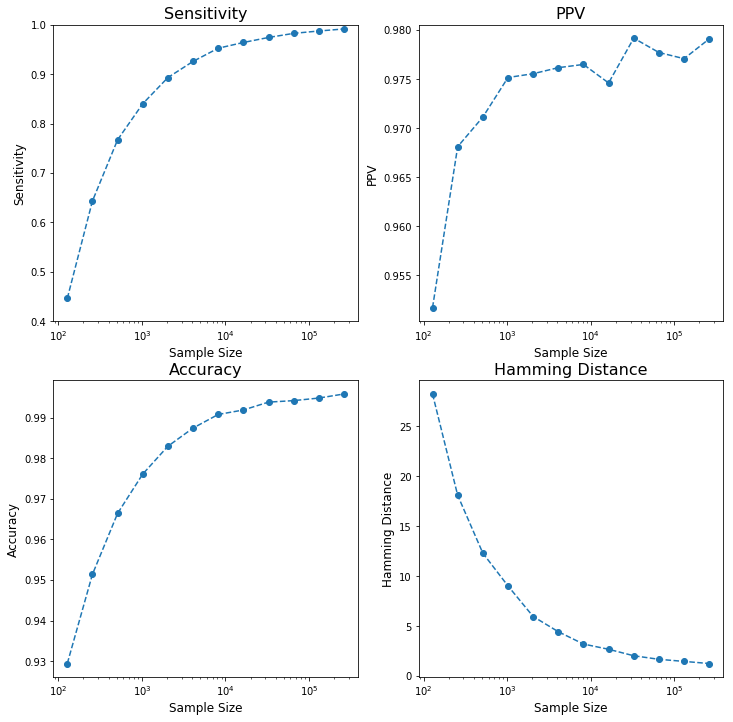

In [25]:
plot_metrics = np.mean(metrics, axis=0)
titles = ['Sensitivity', 'PPV', 'Accuracy', 'Hamming Distance']
plt.figure(figsize=(12,12))
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.plot([2**(7+z) for z in range(num_n)], plot_metrics[:, i], 'o--')
    plt.title(titles[i], fontsize=16)
    plt.ylabel(titles[i], fontsize=12)
    plt.xlabel('Sample Size', fontsize=12)
    plt.xscale('log')
    if i == 0:
        plt.ylim([0.4, 1.0])
plt.show()

## ALPHA IMPACT ON PC ALGORITHM

In [28]:
num_tests = 25
n_values = [(10,50), (10,50), (100, 500), (100, 250)]
d_values = [(10,30), (50, 150), (10,30), (50, 150)]
sig_levels = [0.9999, 0.999, 0.995, 0.99, 0.975, 0.95, 0.9]
clusters = len(n_values)
#metrics = np.zeros((num_tests, clusters, len(sig_levels), 2))

for i, rng in enumerate(n_values):
    if i > 0:
        break
    print('Testing combo number %i' %(i+1))
    nlo, nhi = rng
    dlo, dhi = d_values[i]
    for tt in range(num_tests):
        if tt % 5 == 0:
            print('Iteration #%i' % tt)
        D = np.random.randint(low=dlo, high=dhi+1)
        N = np.random.randint(low=nlo, high=nhi+1)
        ne = 2 + 2*np.random.rand()
        eta = ne / (D-1.0)
        sample_data, pcor = simulate_gaussian_data(N, D, eta)
        actual_network = generate_graph(pcor)
        for j, sig_level in enumerate(sig_levels):
            pc_model = PCAlgorithm(threshold=sig_level)
            pc_model.fit(sample_data)
            sens, spec, fpr, ppv, mcc, f1_score, accuracy, hd = generate_network_metrics(actual_network, pc_model.network_)
            metrics[tt, i, j, :] = [accuracy, hd]

Testing combo number 1
Iteration #0
Iteration #5
Iteration #10
Iteration #15
Iteration #20


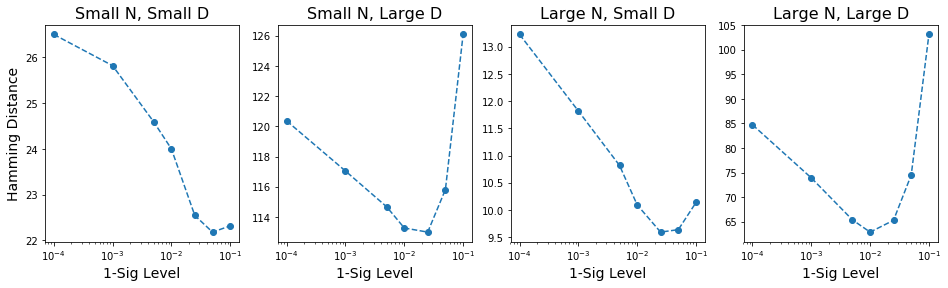

In [29]:
alphas = list(map(lambda x: 1-x, sig_levels))
titles = ['Small N, Small D', 'Small N, Large D', 'Large N, Small D', 'Large N, Large D']
metric_labels = ['Hamming Distance']
plt.figure(figsize=(16,4))
graph_mets = np.mean(metrics[:22,:,:,:], axis=0)
for i in range(4):
    for j in range(1):
        plt.subplot(1,4,i+1 + 4*j)
        plt.plot(alphas, graph_mets[i, :, 1], 'o--')
        if j == 0:
            plt.title(titles[i], fontsize=16)
        if i == 0:
            plt.ylabel(metric_labels[j], fontsize=14)
        plt.xlabel('1-Sig Level', fontsize=14)
        plt.xscale('log')

plt.show()

array([0.99605219, 0.9958566 , 0.99626352, 0.99401651, 0.99240506,
       0.99603243, 0.99680118, 0.98743169, 0.99854711, 0.99810247,
       0.99395297, 0.99188856, 0.99536431, 0.99298359, 0.99450118,
       0.98947368, 0.99825654, 0.98367347, 0.99710946, 0.9973121 ,
       0.99439475, 0.99727703, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ])